In [1]:
from tensorflow.python.client import device_lib
from tcn_sequence_models.data_processing.dataset import DataSet
from tcn_sequence_models.models import TCN_GRU
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

ModuleNotFoundError: No module named 'src'

In [2]:
#set config_path to any path on your system to save models and dataset configs
config_path = "/home/michael/university_courses/TCN_GRU_config"

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1544995453065338055,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7326531584
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5389918801580444628
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:08:00.0, compute capability: 6.1"]

## Load and process data

In [4]:
data_path = "/home/michael/university_courses/lab_course/lab_group_michael_maciej" \
            "/data_vertraulich/building_1/all_months.xlsx"

In [5]:
dataset = DataSet()

In [6]:
dataset.load_data(data_path, file_type="xlsx")


In [9]:
features_input_encoder = [
    "Weather - Outdoor temperature (Logging)",
    "Internal load - Load profile persons (Load profile)",
    "Heizkreis_Heizkoerper - Vorlauftemperatur (Logging)",
]

features_input_decoder = [
    #"Weather - Outdoor temperature (Forecast)",
]

feature_target = "Heizkreis_Heizkoerper - Vorlauftemperatur (Forecast)"


In [16]:
split_ratio = 0.80579
input_seq_len = 250
output_seq_len = 60
smoothing_operations = None
temporal_encoding_modes = ["seasons", "hours", "weekdays", "holidays"]
autoregressive = True


In [17]:
split_date = datetime.date(2019, 1, 1)
# Here we split by data, but you can also split by split_ratio
dataset.process(features_input_encoder,
                features_input_decoder,
                feature_target,
                input_seq_len,
                output_seq_len,
                split_ratio = None,
                split_date = split_date,
                smoothing_operations=smoothing_operations,
                temporal_encoding_modes=temporal_encoding_modes,
                autoregressiive=autoregressive)

seasons
hours
weekdays
holidays


In [18]:
considered_months = [1, 2, 3, 4, 5, 6, 7,]
X_train, y_train, X_val, y_val = dataset.train_test_split_date(split_date, considered_months=considered_months)

# You can also split by split_ratio
#X_train, y_train, X_val, y_val = dataset.train_test_split(split_ratio)

In [19]:
# Save dataset configuration if you want
# dataset.save_dataset_config(config_path)

## Create model and fit it

In [20]:
from tensorflow.keras.optimizers import Adam
model = TCN_GRU(
        )

model.build(
    num_stages_enc = 1,
    num_filters = 6,
    kernel_size_enc = 3,
    dilation_base = 2,
    output_size_attention = 2,
    dropout_rate = 0.3,
    gru_output_neurons = [16],
    key_size = 6,
    value_size = 6,
    num_attention_heads = 2,
    activation = "relu",
    kernel_initializer = "he_normal",
    padding_enc = "causal",
    batch_norm = True,
    layer_norm = False,)
model.compile(optimizer=Adam(lr=0.005, decay=1e-3))



/home/michael/university_courses/lab_course/lab_group_michael_maciej/venv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [21]:
cb_early_stopping = EarlyStopping(patience=1, restore_best_weights=True)
model.fit(X_train,
          y_train,
          (X_val, y_val),
          epochs=20,
          batch_size=64,
          callbacks = cb_early_stopping
          )

Epoch 1/20
629/629 [==============================] - 271s 299ms/step - loss: 0.3392 - val_loss: 0.2882

## Run bayessian optimizer to find the optimal hyperparameters
Uncomment if you want to try it

In [13]:
model.parameter_search(
        X_train,
        y_train,
        X_val,
        y_val,
        batch_size = 64,
        results_path = "param_search_new/search_8",
        patience=2,
        loss = "mse",
        max_trials = 50,
        executions_per_trial = 1,
        num_stages_enc = [1],
        num_filters = [6, 10, 14, 18],
        kernel_size_enc = [3, 5],
        dilation_base = [2],
        dropout_rate = [0.1, 0.2],
        gru_output_neurons = [16],
        key_value_size = [6, 8, 10],
        num_attention_heads = [2],
        output_size_attention = [8],
        activation = ["elu"],
        kernel_initializer = ["he_normal"],
        padding_enc = ["causal"],
        batch_norm = [False],
        layer_norm = [True],
    )


INFO:tensorflow:Reloading Oracle from existing project param_search_new/search_8/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from param_search_new/search_8/untitled_project/tuner0.json

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
num_stages_enc    |1                 |1                 
num_filters       |18                |18                
kernel_size_enc   |5                 |5                 
dilation_base     |2                 |2                 
output_size_att...|8                 |8                 
dropout_rate      |0.1               |0.1               
gru_output_neurons|16                |16                
num_layers_resnet |16                |16                
num_stages_resnet |16                |16                
num_filters_resnet|16                |16                
kernel_size_resnet|16                |16                
key_size          |6                 |6                 
num_attention_h...|2          

KeyboardInterrupt: 

## evaluate the model

In [22]:
# evaluate train and val set with scaling
score_train = model.eval(X_train, y_train, dataset.scaler_y, iterations=1)
print(f"score train: {score_train}")
score_val = model.eval(X_val, y_val, dataset.scaler_y, iterations=1)
print(f"score val: {score_val}")

score train: 71.71226312546281
score val: 74.26649612592583


In [ ]:
# evaluate val set without scaling
score_val = model.eval(X_val, y_val, iterations=1)
print(f"score val: {score_val}")

## Save model if you want to

In [ ]:
# save model
save_path = config_path
model.save_model(save_path)

## Prepare data for plotting

In [24]:
# Make predictions for whole dataset
preds = model.predict(dataset.X, scaler = dataset.scaler_y, iterations=1)
preds_flat = preds.reshape(preds.shape[0], -1)

In [26]:
# Create dataset with predictions
df_with_preds = dataset.create_dataframe_with_predictions(preds_flat)

In [34]:
len(df_with_preds)

96864

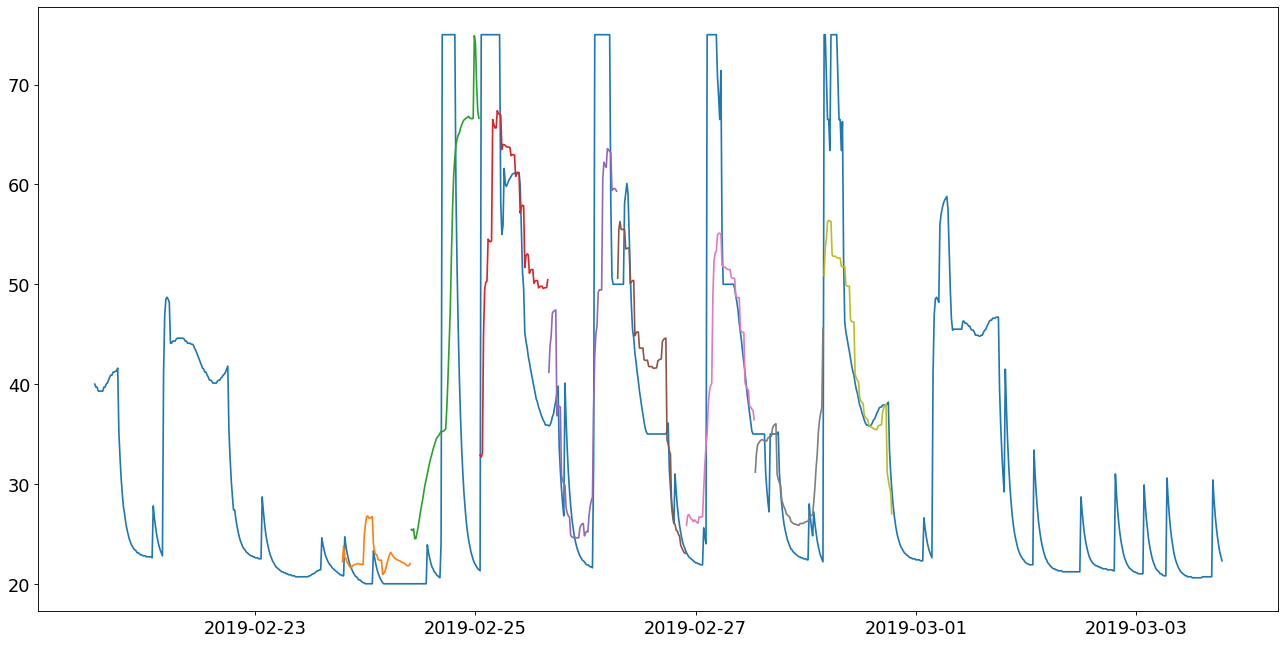

In [38]:
df_chunk = df_with_preds[83000:83984]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-708:-707]
preds_last_2 = df_chunk[["date / time", "predictions"]][-648:-647]
preds_last_3 = df_chunk[["date / time", "predictions"]][-588:-587]
preds_last_4 = df_chunk[["date / time", "predictions"]][-528:-527]
preds_last_5 = df_chunk[["date / time", "predictions"]][-468:-467]
preds_last_6 = df_chunk[["date / time", "predictions"]][-408:-407]
preds_last_7 = df_chunk[["date / time", "predictions"]][-348:-347]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-708],preds_last_0["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-708:-648],preds_last_1["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-648:-588],preds_last_2["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-588:-528],preds_last_3["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-528:-468],preds_last_4["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-468:-408],preds_last_5["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-408:-348],preds_last_6["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-348:-288],preds_last_7["predictions"].values[0] )

In [ ]:
df_chunk = df_with_preds[83500:84484]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0] )


In [ ]:
df_chunk = df_with_preds[84172:85156]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0] )

In [ ]:
df_chunk = df_with_preds[84844:85828]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0] )

In [ ]:
df_chunk = df_with_preds[85516:86500]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0] )

In [ ]:
df_chunk = df_with_preds[91430:92514]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0] )

In [ ]:
df_chunk = df_with_preds[92230:93314]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0] )

In [ ]:
df_chunk = df_with_preds[92895:93979]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0] )

In [ ]:
df_chunk = df_with_preds[93574:94658]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0] )

In [ ]:
df_chunk = df_with_preds[94246:95330]
preds_last_0 = df_chunk[["date / time", "predictions"]][-768:-767]
preds_last_1 = df_chunk[["date / time", "predictions"]][-576:-575]
preds_last_2 = df_chunk[["date / time", "predictions"]][-384:-383]
preds_last_3 = df_chunk[["date / time", "predictions"]][-192:-191]
figure(figsize=(20, 10), dpi=80)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(df_chunk["date / time"], df_chunk["target"])
plt.plot(df_chunk["date / time"][-768:-576],preds_last_0["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-576:-384],preds_last_1["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-384:-192],preds_last_2["predictions"].values[0] )
plt.plot(df_chunk["date / time"][-192:],preds_last_3["predictions"].values[0] )

## Demo on how to load saved models and dataset configs

In [ ]:
# create dataset and model from saved configs
dataset_loaded = DataSet()
dataset_loaded.load_data(data_path, file_type="xlsx")

In [ ]:
split_date = datetime.date(2019, 1, 1)

dataset_loaded.process_from_config\
    (config_path=config_path)

In [ ]:
model = TCN_GRU()
X_call = []
for el in dataset_loaded.X:
    X_call.append(el[:2])
model.load_model(config_path,
                        X_call)

In [ ]:
considered_months = [1, 2, 3, 4, 5, 6, 7,]
X_train, y_train, X_val, y_val = dataset.train_test_split_date(split_date,
                                                               considered_months=considered_months)

In [ ]:
# evaluate train and val set without scaling
score_train = model.eval(X_train, y_train, iterations=10)
print(f"score train: {score_train}")
score_val = model.eval(X_val, y_val, iterations=1)
print(f"score val: {score_val}")